# Computer Vision - Project
imports

In [73]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
import requests
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
import h5py, requests, os
import matplotlib.patches as patches
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [74]:
# IMG_SIZE = (64, 64)
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.resnet(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
# base_model.trainable = False

Constants

In [75]:
#ZIP_PATH = "https://drive.google.com/drive/folders/1jzHYpTwywUYA53nMGHVROSuVO14hEueq?usp=sharing/"
FILE_NAME ="SynthText_train.h5"
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.clear_session()


In [76]:
def sort_points(points, center):
    # calculate the angle of each point from the center point
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    # sort the points by angle
    sorted_points = points[np.argsort(angles)]
    return sorted_points

In [77]:
def draw_points(image, points, color=(255, 0, 0), radius=3):
    # create a copy of the image
    img = image.copy()
    # iterate over the points and draw them on the image
    for point in points:
        cv2.circle(img, tuple(map(int, point)), radius, color, -1)
    return img


In [78]:
def get_bb(img, bbs, indx):
    x1 = int(bbs[0,0,indx])
    y1 = int(bbs[1,0,indx])
    x2 = int(bbs[0,1,indx])
    y2 = int(bbs[1,1,indx])
    x3 = int(bbs[0,2,indx])
    y3 = int(bbs[1,2,indx])
    x4 = int(bbs[0,3,indx])
    y4 = int(bbs[1,3,indx])
    # calculate bounding rectangle
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))
    # points = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    
    # create an empty image with the same shape as the input image
    # mask = np.zeros_like(img[:,:,0])
    # create a list of the bounding box points in the correct format
    # bounding_box = np.array([points], dtype=np.int32)
    # fill the area inside the bounding box with white
    # cv2.fillPoly(mask, bounding_box, 255)
    # apply the mask to the image
    ####res = cv2.bitwise_and(img, mask)
    # try1 = np.array(np.where(mask == 255, 255, 0), dtype=np.uint8)
    # print(x)
    # inv_mask = cv2.bitwise_not(mask)
    # res2 = cv2.bitwise_and(img, inv_mask)
    # bb2 = np.int32([[top_left_x, bot_right_y], [bot_right_x, bot_right_y],[bot_right_x,top_left_y], [top_left_x,top_left_y]])
    # print(bb2)
    # mask2 = np.zeros_like(img)
    # # bb2 = np.array(frame, dtype=np.int32)
    # cv2.fillPoly(mask2, bb2, (255, 255, 255))
    # mask = mask[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    res = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]

    #res = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    #flipping
    """"if(x2 < x1):
        res = cv2.flip(res, 1)
    if(y2 < y1):
        res = cv2.flip(res, 0)
    plt.imshow(mask)
    plt.show()
    print(mask.shape)"""
    return res

In [79]:
def font_to_num(font):
    if font == b'Alex Brush':
        return 0
    elif font == b'Titillium Web':
        return 1
    elif font == b'Sansation':
        return 2
    elif font == b'Open Sans':
        return 3
    else:
        return 4

In [80]:
def num_to_font(font):
    if font == 0:
        return b'Alex Brush'
    elif font == 1:
        return b'Titillium Web'
    elif font == 2:
        return b'Sansation'
    elif font == 3:
        return b'Open Sans'
    else:
        return b'Ubuntu Mono'

In [81]:
def print_label(set, index):
    line = set[index]
    max = np.argmax(line)
    print(num_to_font(max))

In [82]:
def print_font(max):
     print(num_to_font(max))

In [83]:
def print_photo_from_set(set_x, set_y, index, font):
    plt.imshow(set_x[index], cmap='gray')
    plt.show()
    print_font(font)

In [84]:
def prepare_img(img, bbs, index, size):
    cropped = get_bb(img, bbs, index)
    # _, cropped = cv2.threshold(cropped,127,255,cv2.THRESH_TRIANGLE)
    # print(cropped.shape)
    cropped = tf.image.resize(cropped, (size, size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    cropped = tf.image.rgb_to_grayscale(cropped)
    # # print(cropped.shape)
    cropped = tf.image.convert_image_dtype(cropped, tf.float32)
    # plt.imshow(cropped, cmap='gray')
    # plt.show()
    return cropped

In [85]:
from pathlib import Path
def create_dirs():
    Path('main_directory').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Alex Brush').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Titillium Web').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Sansation').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Open Sans').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Ubuntu Mono').mkdir(parents=True, exist_ok=True)

In [86]:
def get_data_set(size: int):
    db = h5py.File(FILE_NAME, 'r')
    create_dirs()
    im_names = list(db['data'].keys())
    train_x = []
    train_y = []
    for i in range(0, len(im_names)-1):
        im = im_names[i]
        img  = db['data'][im][:]
        fonts = db['data'][im].attrs['font']
        txts = db['data'][im].attrs['txt']
        charBBs = db['data'][im].attrs['charBB']
        wordBBs = db['data'][im].attrs['wordBB']
        font_indx = 0 
        char_indx = 0
        # print(im)
        for j in range(0, len(txts)):
            cropped = prepare_img(img, wordBBs, j, size)
            path = 'main_directory/'+fonts[font_indx].decode('UTF-8')+'/'+im+'.jpg'
            # print(path)
            tf.keras.utils.save_img(path,cropped)
            # train_x.append(cropped)
            # train_y.append(font_to_num(fonts[font_indx]))
            
            # plt.imshow(cropped, cmap='gray')
            # plt.show()
            # print(fonts[font_indx])
            for k in range(0, len(txts[j])):
                cropped = prepare_img(img, charBBs, char_indx, size)
                path = 'main_directory/'+fonts[font_indx].decode('UTF-8')+'/'+im+'.jpg'
                # print(path)
                tf.keras.utils.save_img(path,cropped)
                # train_x.append(cropped)
                # train_y.append(font_to_num(fonts[font_indx]))
                char_indx+=1
                # plt.imshow(cropped, cmap='gray')
                # plt.show()
                # print(fonts[font_indx])
            font_indx += len(txts[j])
    return train_x, train_y

In [87]:
SIZE=256
# train_x, train_y = get_data_set(SIZE)

In [88]:
# train_X = np.asarray(train_x, dtype="float") / 255.0
# plt.imshow(train_x[3], cmap='gray')
# print(train_x)

In [89]:
#cut the set for train and validation
# x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [90]:
# Y_train = np_utils.to_categorical(y_train, 5)
# Y_test = np_utils.to_categorical(y_test, 5)

In [91]:
# X_train = np.array(x_train)
# Y_train = np.array(Y_train)
# print(X_train.shape)
# print(Y_train.shape)
# plt.imshow(X_train[2], cmap='gray')


In [92]:
# def preprocessing_function(img):
#     img = tf.image.resize(img, (size, size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#     img = tf.image.rgb_to_grayscale(img)
#     # img = tf.image.convert_image_dtype(img, tf.float32)
#     return img

In [93]:
from keras.preprocessing.image import ImageDataGenerator
def data_augmentation():
    datagen =  ImageDataGenerator(horizontal_flip=True, rotation_range=10, fill_mode='reflect',  
     )
    Path('augmented').mkdir(exist_ok=True)
    it = datagen.flow_from_directory('main_directory', batch_size=10, save_to_dir='augmented')
    return it, datagen

In [94]:
it, datagen = data_augmentation()

Found 3560 images belonging to 5 classes.


In [95]:
# X_mean = X_train.mean(axis=0)
# datagen.fit(X_train - X_mean)
# datagen.mean = X_train.mean(axis=0)
# datagen.std = X_train.std(axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


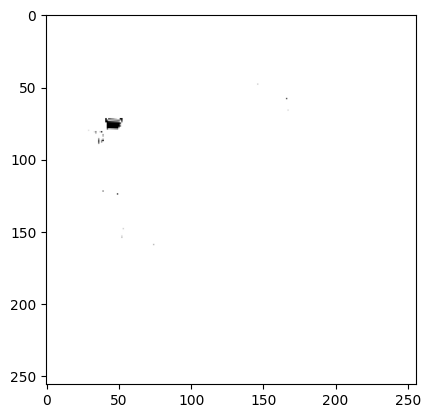

b'Open Sans'


In [96]:
# while(it!=None):
img, label = it.next()
#     # print(img)
#     if(num_to_font(np.argmax(label))==b'Titillium Web'):
plt.imshow(img[0], cmap = 'gray')
plt.show()
print(num_to_font(np.argmax(label)))

In [103]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Resizing

# SIZE=100
visible = Input(shape=(SIZE,SIZE,1))
conv = Conv2D(32, kernel_size=4, activation='relu', padding='same')(visible)
pool = MaxPooling2D(pool_size=(2, 2))(conv)
x = Dropout(0.25)(pool)
conv = Conv2D(32, kernel_size=4, activation='relu', padding='same')(x)
pool = MaxPooling2D(pool_size=(2, 2))(conv)
x = Dropout(0.25)(pool)
conv = Conv2D(64, kernel_size=4, activation='relu', padding='same')(x)
pool = MaxPooling2D(pool_size=(2, 2))(conv)
# x = Dropout(0.25)(pool)
# conv = Conv2D(31, kernel_size=4, activation='relu')(x)
# pool = MaxPooling2D(pool_size=(2, 2))(conv)
# x = Dropout(0.25)(pool)
# conv = Conv2D(16, kernel_size=4, activation='relu')(x)
# pool = MaxPooling2D(pool_size=(2, 2))(conv)
# x = Dropout(0.25)(pool)
flat = Flatten()(x)
hidden1 = Dense(50, activation='sigmoid')(flat)
output = Dense(5, activation='sigmoid')(hidden1)
model = Model(inputs=visible, outputs=output)
# summarize layers
# print(model.summary())
# plot graph
# plot_model(model, to_file='convolutional_neural_network.png')

In [104]:
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [105]:

# opt = tf.keras.optimizers.Adam(learning_rate=10e-5) 
#tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#tf.keras.optimizers.Adam(learning_rate=10e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])

In [106]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [107]:
# X_train = np.array(x_train, dtype='uint8')
# print(X_train.shape)
# print(Y_train.shape)

In [108]:
# model.fit(X_train, Y_train, batch_size=16, epochs=20, verbose=1)
# datagen.fit(X_train)
model.fit(it, epochs=20, verbose=1, callbacks=[callback])

Epoch 1/20
  5/356 [..............................] - ETA: 1:22 - loss: 1.8452 - accuracy: 0.1400 

KeyboardInterrupt: 

In [ ]:
X_test = np.array(x_test)
#np.random.shuffle(Y_test)
score = model.evaluate(X_test, Y_test, verbose=0) 
predict = model.predict(X_test, verbose=0) 

In [ ]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [ ]:
# 0.513256847858429

In [ ]:
indx = 1
plt.imshow(X_test[indx], cmap='gray')
plt.show
print(Y_test[indx])
# print(predict[2])

In [ ]:
# for i in range(0, len(X_test)):
#     predict_index = np.argmax(predict[i])
#     test_index = np.argmax(Y_test[i])
#     if(test_index != predict_index):
#         print(test_index)
#         print(predict_index)
#         print_photo_from_set(X_test, Y_test, i, test_index)
#         print_font(predict_index)
        

In [ ]:
# res = model.predict(X_train[:7])
# print(res) 0.5317240357398987

In [ ]:
# print(Y_train[:7])

In [ ]:
#del model 
#tf.keras.backend.clear_session()

In [ ]:
print(model.summary())